In [ ]:
from google.colab import drive
drive.mount('/content/drive')

data_dir = "/content/drive/MyDrive/Colab Notebooks/인공지능 팀플/archive/chest_xray"
train_dir = data_dir + "/train"
val_dir   = data_dir + "/val"
test_dir  = data_dir + "/test"

import os
print("Train:", os.path.exists(train_dir))
print("Val:  ", os.path.exists(val_dir))
print("Test: ", os.path.exists(test_dir))

Mounted at /content/drive
Train: True
Val:   True
Test:  True


In [ ]:
from torchvision import transforms

mean = [0.485, 0.456, 0.406]
std  = [0.229, 0.224, 0.225]

train_transform = transforms.Compose([
    transforms.Grayscale(num_output_channels=3),
    transforms.Resize((224, 224)),
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.ToTensor(),
    transforms.Normalize(mean, std),
])

val_transform = transforms.Compose([
    transforms.Grayscale(num_output_channels=3),
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean, std),
])

test_transform = val_transform

In [ ]:
from torchvision import datasets
import torch

batch_size = 16

train_dataset = datasets.ImageFolder(train_dir, transform=train_transform)
val_dataset   = datasets.ImageFolder(val_dir, transform=val_transform)
test_dataset  = datasets.ImageFolder(test_dir, transform=test_transform)

train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader   = torch.utils.data.DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
test_loader  = torch.utils.data.DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

class_names = train_dataset.classes

print("Classes:", class_names)
print("Number of Train Images:", len(train_dataset))

Classes: ['NORMAL', 'PNEUMONIA']
Number of Train Images: 5216


In [ ]:
import random, os
import numpy as np
import torch
import torch.nn as nn
from tqdm import tqdm

# 하이퍼파라미터
image_size = 224
batch_size = 16       # 터지면 8로 통일
num_epochs = 20
lr = 1e-4
seed = 42

# seed 고정
random.seed(seed)
np.random.seed(seed)
torch.manual_seed(seed)
torch.cuda.manual_seed_all(seed)

# device (GPU 필수)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Device:", device)

Device: cuda


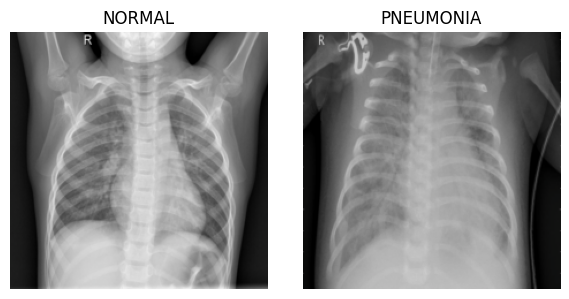

In [ ]:
import matplotlib.pyplot as plt
from torchvision import transforms

# transform에서 썼던 mean, std 다시 정의 (혹시 위 셀에 없다면)
mean = [0.485, 0.456, 0.406]
std  = [0.229, 0.224, 0.225]

# 역정규화
inv_normalize = transforms.Normalize(
    mean=[-m/s for m, s in zip(mean, std)],
    std=[1/s for s in std]
)

def show_one_normal_and_pneumonia_fast(dataset):
    targets = dataset.targets  # [0,1,1,0,...]
    idx_normal = next(i for i, t in enumerate(targets) if t == 0)
    idx_pneu   = next(i for i, t in enumerate(targets) if t == 1)

    imgs = []
    labels = []

    for idx in [idx_normal, idx_pneu]:
        img, label = dataset[idx]               # transform까지 적용된 이미지
        img = inv_normalize(img).permute(1, 2, 0).cpu().numpy()
        imgs.append(np.clip(img, 0, 1))
        labels.append(label)

    plt.figure(figsize=(6, 3))
    for i in range(2):
        plt.subplot(1, 2, i+1)
        plt.imshow(imgs[i])
        plt.axis("off")
        plt.title(class_names[labels[i]])
    plt.tight_layout()
    plt.show()

show_one_normal_and_pneumonia_fast(train_dataset)

In [ ]:
!pip install timm -q

import timm

# ViT-B/16 사전학습 모델
model = timm.create_model("vit_base_patch16_224", pretrained=True)

# head를 이진 분류용(1 logit)으로 교체
in_features = model.head.in_features
model.head = nn.Linear(in_features, 1)

model = model.to(device)

# 손실 함수 / 옵티마이저 (조건 맞춤)
loss_fn = nn.BCEWithLogitsLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=lr)

print(model.head)

/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


model.safetensors:   0%|          | 0.00/346M [00:00<?, ?B/s]

Linear(in_features=768, out_features=1, bias=True)


In [ ]:
def train_one_epoch(model, loader, optimizer, loss_fn, device):
    model.train()
    running_loss = 0.0
    correct = 0
    total = 0

    progress_bar = tqdm(loader, desc="Training", leave=False)

    for images, labels in progress_bar:
        images = images.to(device)
        labels = labels.to(device).float().unsqueeze(1)  # (N,) -> (N,1)

        optimizer.zero_grad()
        outputs = model(images)          # (N,1) logit
        loss = loss_fn(outputs, labels)

        loss.backward()
        optimizer.step()

        running_loss += loss.item() * images.size(0)

        preds = (torch.sigmoid(outputs) > 0.5).int()
        correct += (preds == labels.int()).sum().item()
        total += labels.size(0)

        progress_bar.set_postfix(loss=float(loss.item()))

    epoch_loss = running_loss / total
    epoch_acc  = correct / total
    return epoch_loss, epoch_acc


@torch.no_grad()
def eval_one_epoch(model, loader, loss_fn, device, desc="Validating"):
    model.eval()
    running_loss = 0.0
    correct = 0
    total = 0

    progress_bar = tqdm(loader, desc=desc, leave=False)

    for images, labels in progress_bar:
        images = images.to(device)
        labels = labels.to(device).float().unsqueeze(1)

        outputs = model(images)
        loss = loss_fn(outputs, labels)

        running_loss += loss.item() * images.size(0)

        preds = (torch.sigmoid(outputs) > 0.5).int()
        correct += (preds == labels.int()).sum().item()
        total += labels.size(0)

        progress_bar.set_postfix(loss=float(loss.item()))

    epoch_loss = running_loss / total
    epoch_acc  = correct / total
    return epoch_loss, epoch_acc

In [ ]:
train_losses, val_losses = [], []
train_accuracies, val_accuracies = [], []

best_val_loss = float("inf")
best_model_path = "vit_best.pth"

for epoch in range(num_epochs):
    print(f"\n===== Epoch [{epoch+1}/{num_epochs}] =====")

    train_loss, train_acc = train_one_epoch(model, train_loader, optimizer, loss_fn, device)
    val_loss,   val_acc   = eval_one_epoch(model, val_loader,   loss_fn, device, desc="Validating")

    train_losses.append(train_loss)
    val_losses.append(val_loss)
    train_accuracies.append(train_acc)
    val_accuracies.append(val_acc)

    # best epoch: val_loss 최소
    if val_loss < best_val_loss:
        best_val_loss = val_loss
        torch.save(model.state_dict(), best_model_path)

    print(f"Train Loss: {train_loss:.4f} | Train Acc: {train_acc:.4f}")
    print(f"Val   Loss: {val_loss:.4f} | Val   Acc: {val_acc:.4f}")

print("Best val loss:", best_val_loss)


===== Epoch [1/20] =====


Train Loss: 0.2855 | Train Acc: 0.8723
Val   Loss: 0.8384 | Val   Acc: 0.7500

===== Epoch [2/20] =====


Train Loss: 0.1178 | Train Acc: 0.9569
Val   Loss: 1.4335 | Val   Acc: 0.6875

===== Epoch [3/20] =====


Train Loss: 0.0943 | Train Acc: 0.9659
Val   Loss: 0.7107 | Val   Acc: 0.6875

===== Epoch [4/20] =====


Train Loss: 0.0703 | Train Acc: 0.9739
Val   Loss: 1.4451 | Val   Acc: 0.6250

===== Epoch [5/20] =====


Train Loss: 0.0577 | Train Acc: 0.9781
Val   Loss: 0.6844 | Val   Acc: 0.7500

===== Epoch [6/20] =====


Train Loss: 0.0579 | Train Acc: 0.9780
Val   Loss: 1.7572 | Val   Acc: 0.6875

===== Epoch [7/20] =====


Train Loss: 0.0536 | Train Acc: 0.9806
Val   Loss: 1.5491 | Val   Acc: 0.6875

===== Epoch [8/20] =====


Train Loss: 0.0433 | Train Acc: 0.9831
Val   Loss: 1.2817 | Val   Acc: 0.6875

===== Epoch [9/20] =====


Train Loss: 0.0506 | Train Acc: 0.9820
Val   Loss: 2.9441 | Val   Acc: 0.6875

===== Epoch [10/20] =====


Train Loss: 0.0551 | Train Acc: 0.9795
Val   Loss: 1.4457 | Val   Acc: 0.6875

===== Epoch [11/20] =====


Train Loss: 0.0339 | Train Acc: 0.9877
Val   Loss: 0.8882 | Val   Acc: 0.6875

===== Epoch [12/20] =====


Train Loss: 0.0305 | Train Acc: 0.9887
Val   Loss: 1.1717 | Val   Acc: 0.6875

===== Epoch [13/20] =====


Train Loss: 0.0560 | Train Acc: 0.9783
Val   Loss: 2.0952 | Val   Acc: 0.5000

===== Epoch [14/20] =====


Train Loss: 0.0277 | Train Acc: 0.9893
Val   Loss: 3.8273 | Val   Acc: 0.6250

===== Epoch [15/20] =====


Train Loss: 0.0224 | Train Acc: 0.9919
Val   Loss: 2.2123 | Val   Acc: 0.8125

===== Epoch [16/20] =====


Train Loss: 0.0286 | Train Acc: 0.9898
Val   Loss: 0.2750 | Val   Acc: 0.8750

===== Epoch [17/20] =====


Train Loss: 0.0277 | Train Acc: 0.9898
Val   Loss: 1.2259 | Val   Acc: 0.8750

===== Epoch [18/20] =====


Train Loss: 0.0226 | Train Acc: 0.9923
Val   Loss: 1.0484 | Val   Acc: 0.7500

===== Epoch [19/20] =====


Train Loss: 0.0269 | Train Acc: 0.9904
Val   Loss: 2.5021 | Val   Acc: 0.6875

===== Epoch [20/20] =====


Train Loss: 0.0312 | Train Acc: 0.9898
Val   Loss: 2.2834 | Val   Acc: 0.6875
Best val loss: 0.2749505937099457


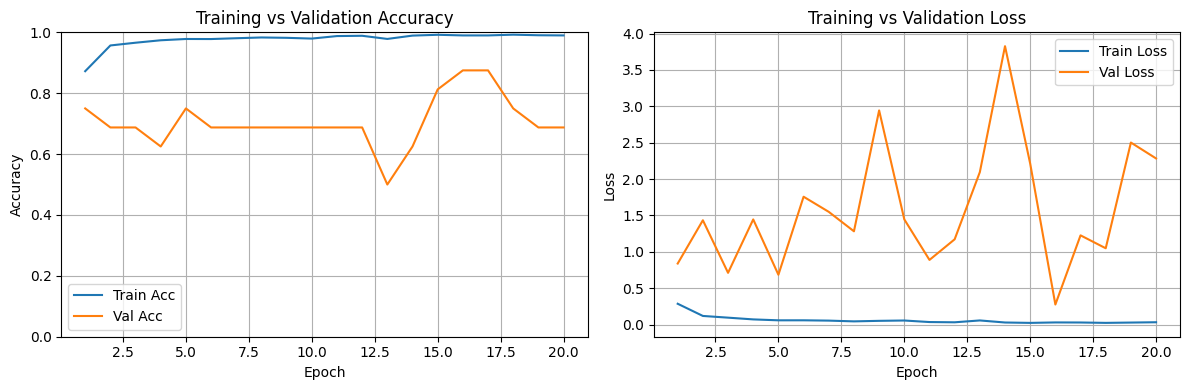

In [ ]:
epochs = range(1, num_epochs + 1)

plt.figure(figsize=(12,4))

# Accuracy
plt.subplot(1, 2, 1)
plt.plot(epochs, train_accuracies, label="Train Acc")
plt.plot(epochs, val_accuracies, label="Val Acc")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.title("Training vs Validation Accuracy")
plt.ylim(0, 1)
plt.grid(True)
plt.legend()

# Loss
plt.subplot(1, 2, 2)
plt.plot(epochs, train_losses, label="Train Loss")
plt.plot(epochs, val_losses, label="Val Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Training vs Validation Loss")
plt.grid(True)
plt.legend()

plt.tight_layout()
plt.show()

In [ ]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix

# best 모델 로드
model.load_state_dict(torch.load(best_model_path))
model.to(device)
model.eval()

all_labels = []
all_preds  = []

with torch.no_grad():
    for images, labels in tqdm(test_loader, desc="Testing"):
        images = images.to(device)
        labels = labels.to(device).float().unsqueeze(1)

        outputs = model(images)
        probs = torch.sigmoid(outputs)
        preds = (probs > 0.5).int()

        all_labels.extend(labels.cpu().numpy().ravel().tolist())
        all_preds.extend(preds.cpu().numpy().ravel().tolist())

acc  = accuracy_score(all_labels, all_preds)
prec = precision_score(all_labels, all_preds)
rec  = recall_score(all_labels, all_preds)
f1   = f1_score(all_labels, all_preds)
cm   = confusion_matrix(all_labels, all_preds)

print("\n[ViT Test Metrics]")
print(f"Accuracy : {acc:.4f}")
print(f"Precision: {prec:.4f}")
print(f"Recall   : {rec:.4f}")
print(f"F1-score : {f1:.4f}")
print("\nConfusion Matrix:\n", cm)

Testing: 100%|██████████| 39/39 [07:39<00:00, 11.79s/it]


[ViT Test Metrics]
Accuracy : 0.8413
Precision: 0.8284
Recall   : 0.9410
F1-score : 0.8812

Confusion Matrix:
 [[158  76]
 [ 23 367]]


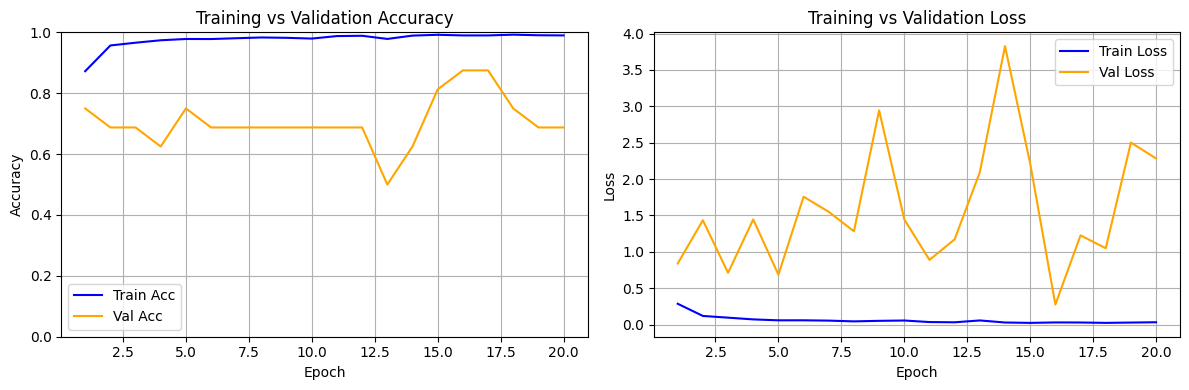

In [ ]:
# ✅ [셀 1] Accuracy & Loss Learning Curve
import matplotlib.pyplot as plt

model_name = "ViT-B/16"  # 팀원은 여기만 변경

epochs = range(1, len(train_accuracies) + 1)

plt.figure(figsize=(12, 4))

# Accuracy Curve
plt.subplot(1, 2, 1)
plt.plot(epochs, train_accuracies, color="blue", label="Train Acc")
plt.plot(epochs, val_accuracies, color="orange", label="Val Acc")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.title("Training vs Validation Accuracy")
plt.ylim(0.0, 1.0)
plt.grid(True)
plt.legend()

# Loss Curve
plt.subplot(1, 2, 2)
plt.plot(epochs, train_losses, color="blue", label="Train Loss")
plt.plot(epochs, val_losses, color="orange", label="Val Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Training vs Validation Loss")
plt.grid(True)
plt.legend()

plt.tight_layout()
plt.show()

In [ ]:
# ✅ [셀 2] Test 성능 지표 출력 (정확한 포맷 통일)
print(f"[{model_name} - Test Metrics]")
print(f"Accuracy : {acc*100:.2f}%")
print(f"Precision: {prec*100:.2f}%")
print(f"Recall   : {rec*100:.2f}%")
print(f"F1-Score : {f1*100:.2f}%")
print("\nConfusion Matrix (Test Set)")
print("(행 = True Class, 열 = Predicted Class)")
print(cm)

[ViT-B/16 - Test Metrics]
Accuracy : 84.13%
Precision: 82.84%
Recall   : 94.10%
F1-Score : 88.12%

Confusion Matrix (Test Set)
(행 = True Class, 열 = Predicted Class)
[[158  76]
 [ 23 367]]


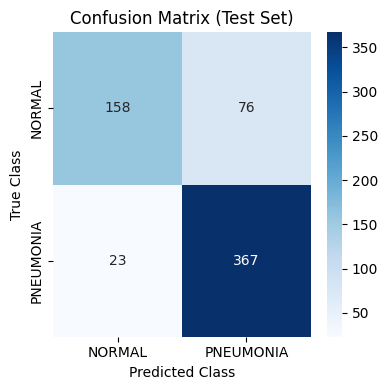

In [ ]:
# ✅ [셀 3] Confusion Matrics
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt

class_labels = ["NORMAL", "PNEUMONIA"]

plt.figure(figsize=(4, 4))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues",
            xticklabels=class_labels,
            yticklabels=class_labels)

plt.xlabel("Predicted Class")
plt.ylabel("True Class")
plt.title("Confusion Matrix (Test Set)")
plt.tight_layout()
plt.show()

In [ ]:
# 모델 저장
torch.save(model.state_dict(), f"{model_name.replace('/', '-')}_best_epoch.pth")

NORMAL example index : 0
PNEUMONIA example index : 234


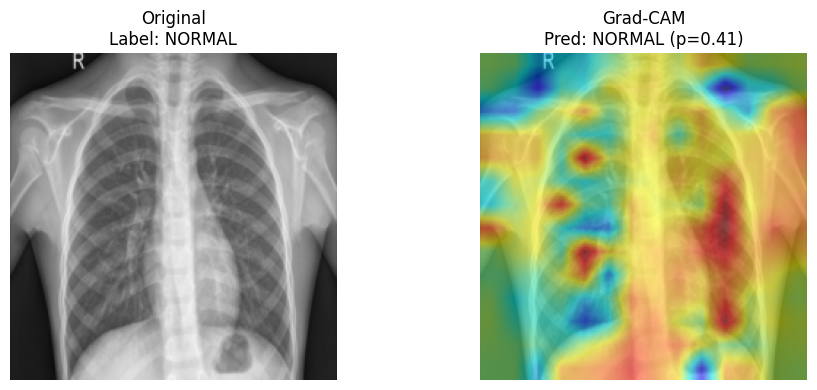

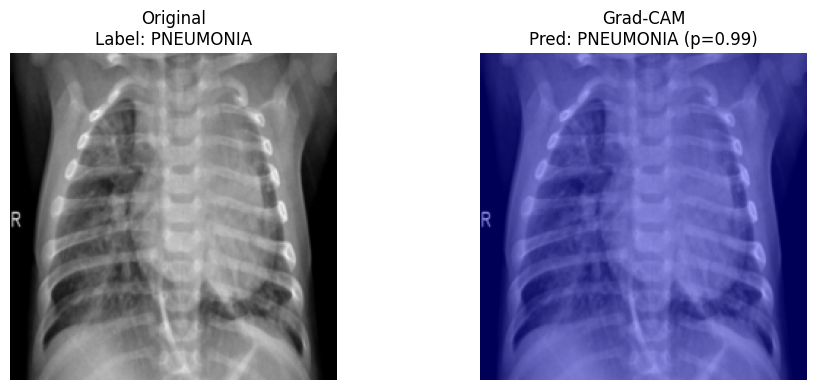

In [ ]:
# === ViT 전용 Grad-CAM 시각화 ===

from pytorch_grad_cam import GradCAM
from pytorch_grad_cam.utils.image import show_cam_on_image
import numpy as np
import matplotlib.pyplot as plt
from torchvision import transforms

# 1) ViT용 reshape_transform 정의
num_patches = model.patch_embed.num_patches   # 224x224, patch16 → 14x14 = 196
h = w = int(num_patches ** 0.5)

def vit_reshape_transform(tensor):
    """
    ViT 토큰 출력 [B, N, C] (CLS + patch 토큰)을
    Grad-CAM이 쓸 수 있는 [B, C, H, W] 형태로 변환
    """
    # 첫 토큰(CLS) 제외 → patch 토큰만 HxW로 재배열
    result = tensor[:, 1:, :].reshape(tensor.size(0), h, w, tensor.size(2))
    # [B, H, W, C] → [B, C, H, W]
    result = result.permute(0, 3, 1, 2)
    return result

# 2) ViT의 마지막 block을 target layer로 사용
target_layers = [model.blocks[-1].norm1]

# 3) Grad-CAM 객체 생성 (⚠ use_cuda 인자 빼야 함)
vit_cam = GradCAM(
    model=model,
    target_layers=target_layers,
    reshape_transform=vit_reshape_transform
)

# 4) 역정규화 (위에서 쓰던 mean, std 재사용)
inv_normalize = transforms.Normalize(
    mean=[-m / s for m, s in zip(mean, std)],
    std=[1 / s for s in std]
)

def visualize_vit_cam(dataset, index):
    """
    dataset에서 index번째 이미지를 가져와
    Original / Grad-CAM 2개 이미지를 나란히 출력
    """
    model.eval()

    # (1) 데이터 가져오기
    img, label = dataset[index]            # transform 적용된 이미지
    input_tensor = img.unsqueeze(0).to(device)

    # (2) 시각화용 원본 이미지 복원 (0~1 범위)
    img_vis = inv_normalize(img).permute(1, 2, 0).cpu().numpy()
    img_vis = np.clip(img_vis, 0, 1)
    if img_vis.shape[2] == 1:             # 혹시 1채널이면 3채널로 반복
        img_vis = np.repeat(img_vis, 3, axis=2)

    # (3) Grad-CAM 계산 (모델이 예측한 클래스 기준)
    grayscale_cam = vit_cam(input_tensor=input_tensor)[0]  # [H, W]
    cam_image = show_cam_on_image(img_vis, grayscale_cam, use_rgb=True)

    # (4) 예측값 / 확률 계산
    with torch.no_grad():
        logit = model(input_tensor)
        prob = torch.sigmoid(logit)[0].item()
        pred = int(prob > 0.5)

    # (5) 시각화
    plt.figure(figsize=(10, 4))

    # Original
    plt.subplot(1, 2, 1)
    plt.imshow(img_vis)
    plt.axis("off")
    plt.title(f"Original\nLabel: {class_names[label]}")

    # Grad-CAM
    plt.subplot(1, 2, 2)
    plt.imshow(cam_image)
    plt.axis("off")
    plt.title(f"Grad-CAM\nPred: {class_names[pred]} (p={prob:.2f})")

    plt.tight_layout()
    plt.show()


# 5) NORMAL / PNEUMONIA 한 장씩 예시 보기
targets = test_dataset.targets
idx_normal = next(i for i, t in enumerate(targets) if t == 0)
idx_pneu   = next(i for i, t in enumerate(targets) if t == 1)

print("NORMAL example index :", idx_normal)
print("PNEUMONIA example index :", idx_pneu)

# 예시 실행 (원하는 것만 골라서 돌려도 됨)
visualize_vit_cam(test_dataset, idx_normal)
visualize_vit_cam(test_dataset, idx_pneu)